# Deep Convolutional Generative Adversarial Network (DCGAN)

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('datasets/MNIST/', one_hot=True)

Extracting datasets/MNIST/train-images-idx3-ubyte.gz
Extracting datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [3]:
# Inputs
image_size = 28
image_channel = 1
image_size_flat = image_size * image_size * image_channel

# Network
filter_size = 5
deconv_filter = 3
conv1_size = 16
conv2_size = 32
conv3_size = 128
fc1_size = 512
fc2_size = 256
fc3_size = 1

# Training
learning_rate = 1e-2
batch_size = 24
iterations = 10000
save_interval = 100
log_interval = 500

## Helper functions

In [4]:
def plot_images(imgs, size=28, name=None):
    grid = int(np.sqrt(len(imgs)))
    fig, axes = plt.subplots(grid, grid)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    if name:
        plt.suptitle(name)
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape([size, size]), cmap='binary', interpolation='bicubic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# def weight(shape, name):
#     initial = tf.truncated_normal(shape=shape, mean=0, stddev=0.4)
#     return tf.Variable(initial, name=name)

# def bias(shape, name):
#     initial = tf.zeros(shape=[shape])
#     return tf.Variable(initial, name=name)

# Weight initializer
def weight(shape, name):
    return tf.get_variable(name, shape, initializer=tf.truncated_normal_initializer(stddev=0.2))

# Bias initializer
def bias(shape, name):
    return tf.get_variable(name, [shape], initializer=tf.zeros_initializer())


def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer
# Convolutional block
def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer

# Deconvolutional block
def deconv_block(layer, W, b, activation_fn=tf.nn.relu, batch_norm=None):
    layer = tf.nn.conv2d(layer, W, strides=[1, 2, 2, 1], padding='SAME')
    layer = layer + b
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, epsilon=1e-5, scope=batch_norm)
    layer = activation_fn(layer)
    return layer

# Fully connected layer
def fully_connected(layer, W, b, use_relu=True):
    layer = tf.matmul(layer, W) + b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

# Flatten layer
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=np.int32).prod()
    flattened = tf.reshape(layer, [-1, features])
    return flattened, features

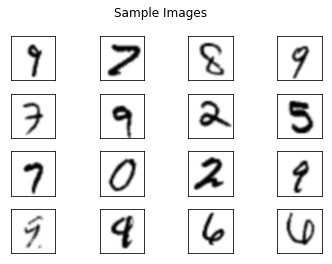

In [5]:
sample_images = data.test.next_batch(16)[0]
plot_images(sample_images, name='Sample Images')

In [6]:
def discriminator(image, reuse=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse):
        # 1st convolutional layer
        W_conv1 = weight(shape=[filter_size, filter_size, image_channel, conv1_size], name='D_W_conv1')
        b_conv1 = bias(shape=conv1_size, name='D_b_conv1')
        conv1 = conv_block(image, W_conv1, b_conv1)
        # 2nd convolutional layer
        W_conv2 = weight(shape=[filter_size, filter_size, conv1_size, conv2_size], name='D_W_conv2')
        b_conv2 = bias(shape=conv2_size, name='D_b_conv2')
        conv2 = conv_block(conv1, W_conv2, b_conv2)
        # 2nd convolutional layer
        W_conv3 = weight(shape=[filter_size, filter_size, conv2_size, conv3_size], name='D_W_conv3')
        b_conv3 = bias(shape=conv3_size, name='D_b_conv3')
        conv3 = conv_block(conv2, W_conv3, b_conv3)
        # Flatten
        flattened, flat_size = flatten(layer=conv3)
        # 1st Fully connected layer
        W_fc1 = weight(shape=[flat_size, fc1_size], name='D_W_fc1')
        b_fc1 = bias(shape=fc1_size, name='D_b_fc1')
        fc1 = fully_connected(flattened, W_fc1, b_fc1)
        # 2nd Fully connected layer
        W_fc2 = weight(shape=[fc1_size, fc2_size], name='D_W_fc2')
        b_fc2 = bias(shape=fc2_size, name='D_b_fc2')
        fc2 = fully_connected(fc1, W_fc2, b_fc2)
        # Classification layer
        W_classify = weight(shape=[fc1_size, fc3_size], name='D_W_classify')
        b_classify = bias(shape=fc3_size, name='D_b_classify')
        classify = fully_connected(fc1, W_classify, b_classify, use_relu=False)
        return classify

In [10]:
def generator(noise, batch_size, noise_dim):
    scale = (image_size + image_size)  # 56  168-3channels
    up_scale = scale * scale  # 3,136  28,224
    # 1st Deconvolutional block
    g_deconv_W1 = weight(shape=[z_dim, up_scale], name='G_W_deconv1')
    g_deconv_b1 = bias(shape=up_scale, name='G_b_deconv1')
    g_deconv_1 = tf.matmul(noise, g_deconv_W1) + g_deconv_b1
    g_deconv_1 = tf.reshape(g_deconv_1, [-1, scale, scale, image_channel])
    g_deconv_1 = tf.contrib.layers.batch_norm(g_deconv_1, epsilon=1e-5, scope='bn_G1')
    g_deconv_1 = tf.nn.relu(g_deconv_1)
    # 2nd Deconvolutional block
    g_deconv_W2 = weight(shape=[deconv_filter, deconv_filter, image_channel, noise_dim//2], name='G_W_deconv2')
    g_deconv_b2 = bias(shape=noise_dim//2, name='G_b_deconv2')
    g_deconv_2 = deconv_block(g_deconv_1, g_deconv_W2, g_deconv_b2, batch_norm='bn_G2')
    g_deconv_2 = tf.image.resize_images(g_deconv_2, [scale, scale])
    # 3rd Deconvolutional block
    g_deconv_W3 = weight(shape=[deconv_filter, deconv_filter, noise_dim//2, noise_dim//4], name='G_W_deconv3')
    g_deconv_b3 = bias(shape=noise_dim//4, name='G_b_deconv3')
    g_deconv_3 = deconv_block(g_deconv_2, g_deconv_W3, g_deconv_b3, batch_norm='bn_G3')
    g_deconv_3 = tf.image.resize_images(g_deconv_3, [scale, scale])
    # Final Deconvolutional block
    g_deconv_W4 = weight(shape=[1, 1, noise_dim//4, image_channel], name='G_W_image')
    g_deconv_b4 = bias(shape=image_channel, name='G_b_image')
    image = deconv_block(g_deconv_3, g_deconv_W4, g_deconv_b4, activation_fn=tf.nn.sigmoid)
    return image

In [11]:
tf.reset_default_graph()
z_dim = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dim])

In [12]:
gen_img = generator(z_placeholder, 1, z_dim)
z_batch = np.random.normal(0, 1, [1, z_dim])

(1, 28, 28, 1)


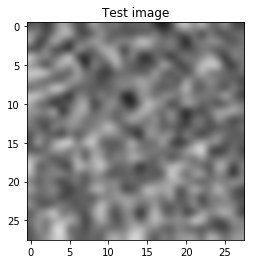

In [13]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_img = sess.run(gen_img, feed_dict={z_placeholder: z_batch})
    print(test_img.shape)
    plt.title('Test image')
    plt.imshow(test_img.reshape([image_size, image_size]), interpolation='bicubic', cmap='binary')

In [14]:
tf.reset_default_graph()

# Placeholder
z_placeholder = tf.placeholder(tf.float32, [None, z_dim], name='z_placeholder')
X_placeholder = tf.placeholder(tf.float32, [None, image_size_flat], name='X_placeholder')
X_image = tf.reshape(X_placeholder, [-1, image_size, image_size, image_channel])

# Genenrated img
Gz = generator(z_placeholder, batch_size, z_dim)
# Discriminator
# Prob. for real img
Dx = discriminator(X_image)
# Prob. for generated img
Dg = discriminator(Gz, reuse=True)

In [15]:
# Discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
# Generator loss
g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [16]:
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'D_' in var.name]
g_vars = [var for var in t_vars if 'G_' in var.name]

print([var.name for var in d_vars])
print([var.name for var in g_vars])

['D_W_conv1:0', 'D_b_conv1:0', 'D_W_conv2:0', 'D_b_conv2:0', 'D_W_conv3:0', 'D_b_conv3:0', 'D_W_fc1:0', 'D_b_fc1:0', 'D_W_fc2:0', 'D_b_fc2:0', 'D_W_classify:0', 'D_b_classify:0']
['G_W_deconv1:0', 'G_b_deconv1:0', 'G_W_deconv2:0', 'G_b_deconv2:0', 'G_W_deconv3:0', 'G_b_deconv3:0', 'G_W_image:0', 'G_b_image:0']


In [17]:
# Discriminator optimization
d_opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_real, var_list=d_vars)
d_opt_fake = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_fake, var_list=d_vars)
# Generator optimization
g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

## Tensorflow's `Session`

In [18]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## Tensorboard

In [20]:
saver = tf.train.Saver()

# Henceforth, reuse variables
tf.get_variable_scope().reuse_variables()

# Summaries
tf.summary.scalar('Generator_Loss', g_loss)
tf.summary.scalar('Discriminator_Loss_Real', d_loss_real)
tf.summary.scalar('Discriminator_Loss_Fake', d_loss_fake)
img_4_tensorboard = generator(z_placeholder, batch_size, z_dim)
tf.summary.image('Generated_Images', img_4_tensorboard, max_outputs=5)
# merge all summaries
merged = tf.summary.merge_all()

# Directories
tensorboard_dir = 'tensorboard/'
logdir = os.path.join(tensorboard_dir, '{:%d-%b-%Y  %H-%M-%S-%p}'.format(dt.datetime.now()))
save_path = 'models/'

writer = tf.summary.FileWriter(logdir, sess.graph)

# Create checkpoint dir
if tf.gfile.Exists(save_path):
    if len(tf.gfile.ListDirectory(save_path)) > 1:
        saver.restore(sess=sess, save_path=save_path)
else:
    tf.gfile.MakeDirs(save_path)

## Training

Iters: 100	Discriminator's loss:– real: 0.000000 fake: 0.000000	Training time: 0:00:21.576953	Iterations: 0 at Fri Nov 03, 2017 at 23:42:32 PM


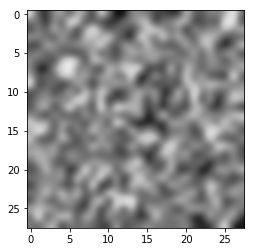

Estimate: [[-2664.73364258]]

Iterations: 10	Training time: 0:00:09.019064	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000

KeyboardInterrupt: 

In [23]:
train_start = dt.datetime.now()
# Pre-train discriminator
for i in range(100):
    fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])
    real_img_batch = data.test.next_batch(batch_size)[0]
    _, _, d_real, d_fake = sess.run([d_opt_fake, d_opt_real, 
                                     d_loss_real, d_loss_fake],
                                    feed_dict={X_placeholder: real_img_batch, 
                                               z_placeholder: fake_img_batch})

    sys.stdout.write('\rIters: {:,}\tDiscriminator\'s loss:– real: {:.6f} fake: {:.6f}\tTraining time: {}'
                     .format(i+1, d_real, d_fake, dt.datetime.now() - train_start))

# Train generator & discriminator together (dual each other)
train_start = dt.datetime.now()
for i in range(iterations):
    real_img_batch = data.test.next_batch(batch_size)[0]
    fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])
    # Train discriminator
    _, _, d_real, d_fake = sess.run([d_opt_fake, d_opt_real,
                                     d_loss_real, d_loss_fake],
                                    feed_dict={X_placeholder: real_img_batch,
                                               z_placeholder: fake_img_batch})
    # Train generator
    gen_img = np.random.normal(0, 1, size=[batch_size, z_dim])
    _, gen_loss = sess.run([g_opt, g_loss], feed_dict={z_placeholder: gen_img})
    
    # Updating tensorboard
    if i % 10 == 0:
        # save model chkpt
        saver.save(sess=sess, save_path=save_path)
        # update tensorboard
        gen_img = np.random.normal(0, 1, size=[batch_size, z_dim])
        summary = sess.run(merged, feed_dict={X_placeholder: real_img_batch,
                                              z_placeholder: gen_img})
        writer.add_summary(summary=summary, global_step=i)
    # Logging
    if i % 1000 == 0:
        # Every 1000 iterations, show a generated image
        print("\tIterations: {:,} at {:%a %h %d, %Y at %H:%M:%S %p}".format(i, dt.datetime.now()))
        gen_img = np.random.normal(0, 1, size=[1, z_dim])
        generated_images = generator(z_placeholder, 1, z_dim)
        images = sess.run(generated_images, {z_placeholder: gen_img})
        plt.imshow(images[0].reshape([image_size, image_size]), interpolation='bicubic', cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0]
        result = discriminator(tf.reshape(X_placeholder, [-1, image_size, image_size, image_channel]))
        estimate = sess.run(result, {X_placeholder: np.reshape(im, [-1, image_size_flat])})
        print("Estimate: {}\n".format(estimate))
    sys.stdout.write('\rIterations: {:,}\tTraining time: {}\td_loss_fake: {:.4f}\td_loss_real: {:.4f}\tg_loss: {:.4f}'
                     .format(i+1, dt.datetime.now() - train_start, d_fake, d_real, gen_loss))
